In [1]:
## Imports ##
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers import UpSampling1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


# Load Data

In [2]:
## Read in Sequence Data

# Raw Data
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# Sequence Context
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"
def reconstruct_seq(utr):
    return upstream_constant+utr+eGFP+downstream_addition

In [4]:
## Split into Train, Validation, and Test Datasets

# Stay sorted by read count, at least for now

# The test set has 25k sequences
# The validation set has 15k sequences 
# The train set has 230k sequences
test = df[:25000].copy()
validate = df[25000:40000].copy()
train = df[40000:280000].copy()

# Scale the label (column name = 'rl') for each dataset independently, to avoid info leakage
test['scaled_rl'] = preprocessing.StandardScaler().fit_transform(test['rl'].values.reshape(-1,1))
validate['scaled_rl'] = preprocessing.StandardScaler().fit_transform(validate['rl'].values.reshape(-1,1))
train['scaled_rl'] = preprocessing.StandardScaler().fit_transform(train['rl'].values.reshape(-1,1))

# Label the datasets
test['dataset'] = 'test'
validate['dataset'] = 'validate'
train['dataset'] = 'train'

In [5]:
len(upstream_constant[-25:])

25

In [6]:
def one_hot_encode(seqs,add_context=False):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}
    
    if add_context:
        seqs = [ upstream_constant[-25:]+s+eGFP[:25] for s in seqs ]
    
    # Creat empty matrix.
    vectors=np.empty([len(seqs),len(seqs[0]),4])
    
    # Encode sequences
    for i,seq in enumerate(seqs):
        a = [ nuc_d[bp] for bp in seq ]
        vectors[i] = a
    
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

# Create Models

In [7]:
LOSS_FN = 'mean_squared_error'
LEARNING_RATE = 0.001
OPTIMIZER = 'adam'
BATCH_SIZE = 128
METRICS = ['mse','acc']

In [8]:
def create_model(n_layers,n_filters,kernel_size,dense_layer_size,dropouts=0.0,dense_dropout=0.0,
                 random_seed_value=1337,input_len=100,input_features=4,padding_mode="same"):
    # Initialize values
    np.random.seed(random_seed_value)
    first_layer_filters = n_filters[0] if type(n_filters) == list else n_filters 
    first_layer_dropout = dropouts[0] if type(dropouts) == list else dropouts
    
    # First CNN Layer
    model = Sequential()
    model.add(Conv1D(activation="relu", input_shape=(input_len, input_features),
                     padding=padding_mode, filters=first_layer_filters,kernel_size=kernel_size))
    model.add(Dropout(first_layer_dropout))
    
    # Rest of CNN Layers
    for i in range(1,n_layers):
        filters = n_filters[i] if type(n_filters) == list else n_filters
        dropout = dropouts[i] if type(dropouts) == list else dropouts
        
        model.add(Conv1D(activation="relu", input_shape=(input_len, 1),
                     padding=padding_mode, filters=filters,kernel_size=kernel_size))
        model.add(Dropout(dropout))
        
    # Dense Layer
    model.add(Flatten())

    model.add(Dense(dense_layer_size))
    model.add(Activation('relu'))
    model.add(Dropout(dense_dropout))
    
    # Output Layer
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    return model

In [9]:
def train_model(model,X_train,Y_train,validation_tuple,nb_epochs,loss_function=LOSS_FN,
                learning_rate=LEARNING_RATE,batch_size=BATCH_SIZE,rsv=1337):
    
    #Create optimizer
    adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # ... add other options later
    
    #Compile the model
    np.random.seed(rsv)
    model.compile(loss=loss_function, optimizer=adam)
    
    #Train the model
    model.fit(X_train,Y_train,validation_data=validation_tuple,epochs=nb_epochs,
              batch_size=batch_size,verbose=1)
    
    return model
    

In [10]:
def test_dataset(model,df,test_seqs,yheader,output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    X_test = test_seqs
    Y_test = df[yheader]
    
    # Create Scaler fitted to test data
    scaler = preprocessing.StandardScaler()
    scaler.fit(Y_test.values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seqs).reshape(-1)
    
    # Inverse scale predicted mean ribosome load before returning as new column
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    df.loc[:,output_col+'_error'] = Y_test - df[output_col]
    return df

In [11]:
X_train_seq = one_hot_encode(train['utr'].values,add_context=True)
X_test_seq = one_hot_encode(test['utr'].values,add_context=True)
X_valid_seq = one_hot_encode(validate['utr'].values,add_context=True)

# train with the scaled values, but test with the raw ones (because test fn does the back and forth conversion)
Y_train_scaled = train['scaled_rl'].values
Y_valid_scaled = validate['scaled_rl'].values

# Grid Search on Hyperparameters

Start with a very broad grid search, and then repeat with a finer-grained search on the best values  

Optimizers: adam, nadam, adagrad  
Learning Rates: 0.001, 0.01, 0.0001  (stay at 0.1 for adagrad)

Number of Layers: 2, 5, 10, 20   
Numbers of Filters: 10, 20, 50, 100  
Kernel Lengths: 3, 7, 15, 30 (adding some knowledge about codon sizes here)  
Dense Layer Sizes: 10, 20, 50, 100

### Coarse-Grained Search

In [12]:
def make_name(L,F,K,D,E):
    return str(L)+'L'+str(F)+'F'+str(K)+'K'+str(D)+'D'+str(E)+'E'+'_CNN'

In [60]:
grid_search_results = {}

# train for 3 epochs to start with
np.random.seed(1337)
for nbr_layers in [10,5,2]:
    for nbr_filters in [10,30,80]:
        for len_kernel in [3,7,15]:
            for dense_size in [40]: #[10,50,100]  in some larger models, 10 dense nodes doesn't train at all
                    if (nbr_layers > 10) and (nbr_filters > 50):
                        pass
                    else:
                        model_name = make_name(nbr_layers,nbr_filters,len_kernel,dense_size,3)
                        print model_name
                        
                        model = create_model(n_layers=nbr_layers,n_filters=nbr_filters,kernel_size=len_kernel,dense_layer_size=dense_size,dense_dropout=dense_dropout)
                        model = train_model(model,X_train_seq,Y_train_scaled,(X_valid_seq,Y_valid_scaled),3)
                        validate = test_dataset(model,validate,X_valid_seq,yheader='rl',output_col=model_name+'_pred')
                        
                        r = r2(validate['rl'],validate[model_name+'_pred'])
                        print 'r-squared is:', r
                        
                        grid_search_results[model_name] = r
                        model.save('./saved_models/gridsearch/'+model_name+'.hdf5')                 

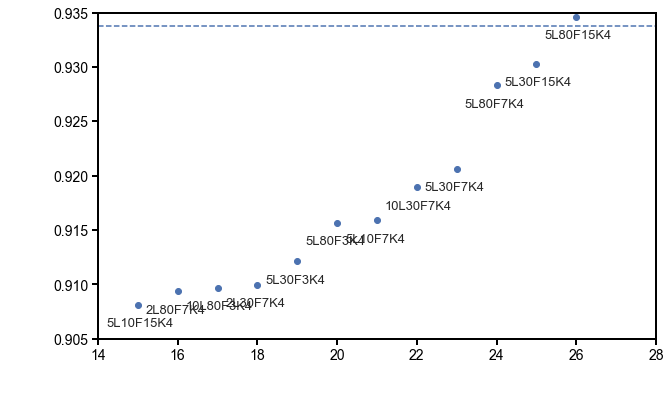

In [93]:
x = np.arange(0,len(grid_search_results))
gs = sorted([ (r,n) for n,r in grid_search_results.items() ])
y,names = zip(*gs)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set_ylim(0.905,0.935)
ax.set_xlim(14,28)
ax.axhline(y=0.9338, linestyle='--')

for i, txt in enumerate(names):
    ax.annotate(txt[:-6], (x[i]-0.8, y[i]-0.002),fontsize=13)

**Layers:** 2 (2/12),  *5 (8/12)*,  10 (2/12)    
**Filters:** 10 (2/12),  *30 (5/12),  80 (5/12)*  
**Kernel Lengths:** 3 (3/12),  *7 (6/12)*,  15(3/12)

### Observations from Gridsearch


In [66]:
grid_search_results2 = {}

# train for 4 epochs instead of 3
np.random.seed(1337)
for nbr_layers in [3,4,5,6,7]:
    for nbr_filters in [20,40,60,80]:
        for len_kernel in [6,7,8]:
            for dense_size in [50]:
                    model_name = make_name(nbr_layers,nbr_filters,len_kernel,dense_size,4)
                    print model_name

                    model = create_model(n_layers=nbr_layers,n_filters=nbr_filters,kernel_size=len_kernel,dense_layer_size=dense_size,dense_dropout=dense_dropout)
                    model = train_model(model,X_train_seq,Y_train_scaled,(X_valid_seq,Y_valid_scaled),4)
                    validate = test_dataset(model,validate,X_valid_seq,yheader='rl',output_col=model_name+'_pred')

                    r = r2(validate['rl'],validate[model_name+'_pred'])
                    print 'r-squared is:', r

                    grid_search_results2[model_name] = r
                    model.save('./saved_models/gridsearch/'+model_name+'.hdf5')
                    
# Check logs for candidate models to see which ones are overtraining!

# wow seems like literally all of these are overtraining in the 4th epoch. Stick with 3 in the future

3L20F6K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [==============================] - 40s 165us/step - loss: 0.3015 - val_loss: 0.1280
Epoch 2/4
240000/240000 [==============================] - 38s 158us/step - loss: 0.1495 - val_loss: 0.1142
Epoch 3/4
240000/240000 [==============================] - 38s 158us/step - loss: 0.1321 - val_loss: 0.1010
Epoch 4/4
240000/240000 [==============================] - 34s 143us/step - loss: 0.1255 - val_loss: 0.1156
r-squared is: 0.9234284587809464
3L20F7K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [==============================] - 45s 187us/step - loss: 0.3088 - val_loss: 0.1473
Epoch 2/4
240000/240000 [==============================] - 38s 158us/step - loss: 0.1526 - val_loss: 0.1194
Epoch 3/4
240000/240000 [==============================] - 39s 163us/step - loss: 0.1311 - val_loss: 0.0885
Epoch 4/4
240000/240000 [==============================] - 38s 157us/step -

240000/240000 [==============================] - 84s 351us/step - loss: 0.1405 - val_loss: 0.1121
Epoch 3/4
240000/240000 [==============================] - 99s 414us/step - loss: 0.1272 - val_loss: 0.0856
Epoch 4/4
240000/240000 [==============================] - 92s 384us/step - loss: 0.1209 - val_loss: 0.1186
r-squared is: 0.9282052019981222
4L40F7K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [==============================] - 120s 501us/step - loss: 0.2478 - val_loss: 0.1097
Epoch 2/4
240000/240000 [==============================] - 107s 448us/step - loss: 0.1285 - val_loss: 0.0921
Epoch 3/4
240000/240000 [==============================] - 113s 473us/step - loss: 0.1194 - val_loss: 0.0854
Epoch 4/4
240000/240000 [==============================] - 109s 455us/step - loss: 0.1151 - val_loss: 0.0987
r-squared is: 0.9318953176306695
4L40F8K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [=======================

r-squared is: 0.9310650050929848
6L80F7K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [==============================] - 358s 1ms/step - loss: 1.0001 - val_loss: 1.0001
Epoch 2/4
240000/240000 [==============================] - 350s 1ms/step - loss: 1.0001 - val_loss: 1.0000
Epoch 3/4
240000/240000 [==============================] - 351s 1ms/step - loss: 1.0000 - val_loss: 1.0003
Epoch 4/4
240000/240000 [==============================] - 19518s 81ms/step - loss: 1.0000 - val_loss: 1.0000
r-squared is: 0.0
6L80F8K50D4E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/4
240000/240000 [==============================] - 3026s 13ms/step - loss: 1.0001 - val_loss: 1.0001
Epoch 2/4
240000/240000 [==============================] - 506s 2ms/step - loss: 1.0001 - val_loss: 1.0000
Epoch 3/4
240000/240000 [==============================] - 543s 2ms/step - loss: 1.0000 - val_loss: 1.0003
Epoch 4/4
240000/240000 [==============================] - 

In [67]:
# could do a seaborn facetgrid type thing here with the results from this gridsearch;
# the name parsing doesn't have the same 2-or-3-digits issue as in the first one


# Still good based on minimum loss despite E4 loss:
# 5L20F7K50D4E_CNN


In [ ]:
# Retry with only 3 epochs? Or is that too much compute time

In [71]:
len(grid_search_results2)

60

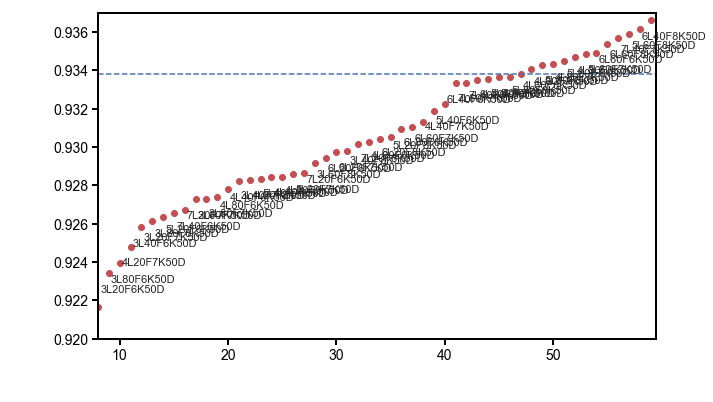

In [86]:
x = np.arange(0,len(grid_search_results2))
gs = sorted([ (r,n) for n,r in grid_search_results2.items() ])
y,names = zip(*gs)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y,color='r')
ax.set_ylim(0.92,0.937)
ax.set_xlim(8,59.5)
ax.axhline(y=0.9338, linestyle='--')

for i, txt in enumerate(names):
    ax.annotate(txt[:-6], (x[i]-0.8, y[i]-0.001),fontsize=11)

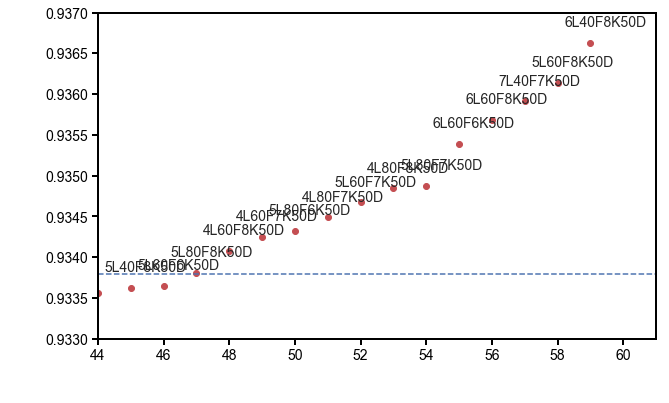

In [121]:
x = np.arange(0,len(grid_search_results2))
gs = sorted([ (r,n) for n,r in grid_search_results2.items() ])
y,names = zip(*gs)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y,color='r')
ax.set_ylim(0.933,0.937)
ax.set_xlim(44,61)
ax.axhline(y=0.9338, linestyle='--')

for i, txt in enumerate(names):
    ax.annotate(txt[:-6], (x[i]-0.8, y[i]+0.0002),fontsize=14)

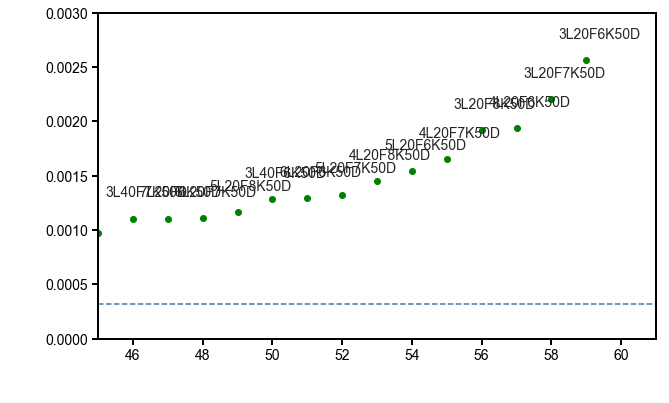

In [124]:
# try making the above chart but do r2-per-node, so control for total size of network!
def parseName(name):
    d = {
        'layers':int(name[0]),
        'filters':int(name[2:4]),
        'kernel_length':int(name[5:6]),
        'dense_size':int(name[7:9]),
        'label':name
    }
    return d
def adjust_r2(r,name):
    d = parseName(name)
    return (r/(d['layers'] * d['filters'] * d['kernel_length']),d)

gs_adjusted = sorted([ adjust_r2(r,n) for r,n in gs ])
y_adj,dict_adj = zip(*gs_adjusted)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y_adj,color='green')
ax.set_ylim(0.0,0.003)
ax.set_xlim(45,61)
ax.axhline(y=(0.9338 / (3 * 120 * 8)), linestyle='--') #author's model

names_adj = [d['label'] for d in dict_adj]
for i, txt in enumerate(names_adj):
    ax.annotate(txt[:-6], (x[i]-0.8, y_adj[i]+0.0002),fontsize=14)

In [130]:
## Combined Gridsearch "hits" (Arbitrary top 20)
hits_adj = names_adj[:20]
hits = names[:20]

for i in range(20):
    print sorted(hits_adj)[i], "\t", sorted(hits)[i]
    
print
print sorted(list(set(hits_adj).intersection(set(hits))))

4L80F7K50D4E_CNN 	3L20F6K50D4E_CNN
4L80F8K50D4E_CNN 	3L20F7K50D4E_CNN
5L60F7K50D4E_CNN 	3L20F8K50D4E_CNN
5L60F8K50D4E_CNN 	3L40F6K50D4E_CNN
5L80F6K50D4E_CNN 	3L60F6K50D4E_CNN
5L80F7K50D4E_CNN 	3L60F7K50D4E_CNN
5L80F8K50D4E_CNN 	3L80F6K50D4E_CNN
6L60F6K50D4E_CNN 	3L80F7K50D4E_CNN
6L60F7K50D4E_CNN 	3L80F8K50D4E_CNN
6L60F8K50D4E_CNN 	4L20F7K50D4E_CNN
6L80F6K50D4E_CNN 	5L20F6K50D4E_CNN
6L80F7K50D4E_CNN 	6L80F7K50D4E_CNN
6L80F8K50D4E_CNN 	6L80F8K50D4E_CNN
7L40F8K50D4E_CNN 	7L20F7K50D4E_CNN
7L60F6K50D4E_CNN 	7L40F6K50D4E_CNN
7L60F7K50D4E_CNN 	7L60F6K50D4E_CNN
7L60F8K50D4E_CNN 	7L60F8K50D4E_CNN
7L80F6K50D4E_CNN 	7L80F6K50D4E_CNN
7L80F7K50D4E_CNN 	7L80F7K50D4E_CNN
7L80F8K50D4E_CNN 	7L80F8K50D4E_CNN

['6L80F7K50D4E_CNN', '6L80F8K50D4E_CNN', '7L60F6K50D4E_CNN', '7L60F8K50D4E_CNN', '7L80F6K50D4E_CNN', '7L80F7K50D4E_CNN', '7L80F8K50D4E_CNN']


In [ ]:
# Pick 2-4 variations to test independently? 
# alternate additional gridsearch idea: pick a total number of nodes, test different architectures!

## Brief Architecture Test

In [139]:
# 150 filter units total
m1 = create_model(n_layers=2,n_filters=60,kernel_size=7,dense_layer_size=30) #(2 * 60) + 30 = 150
m2 = create_model(n_layers=3,n_filters=40,kernel_size=7,dense_layer_size=30) #(3 * 40) + 30 = 150
m3a = create_model(n_layers=4,n_filters=30,kernel_size=7,dense_layer_size=30) #(4 * 30) + 30 = 150
m3b = create_model(n_layers=3,n_filters=30,kernel_size=7,dense_layer_size=60) #(3 * 30) + 60 = 150
m4 = create_model(n_layers=5,n_filters=24,kernel_size=7,dense_layer_size=30) #(5 * 24) + 30 = 150

In [138]:
for name,model in zip(['2L60FK7D30','3L40FK7D30','4L30FK7D30','3L30FK7D60','5L24FK7D30'],[m1,m2,m3a,m3b,m4]):
    model = train_model(model,X_train_seq,Y_train_scaled,(X_valid_seq,Y_valid_scaled),3)
    validate = test_dataset(model,validate,X_valid_seq,yheader='rl',output_col=name+'_pred')
    r = r2(validate['rl'],validate[name+'_pred'])
    print 'validation r-squared is:', r

Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 93s 388us/step - loss: 0.2111 - val_loss: 0.1310
Epoch 2/3
240000/240000 [==============================] - 66s 276us/step - loss: 0.1570 - val_loss: 0.1389
Epoch 3/3
240000/240000 [==============================] - 75s 314us/step - loss: 0.1458 - val_loss: 0.1140
validation r-squared is: 0.9084887672017454
Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 96s 399us/step - loss: 0.2708 - val_loss: 0.1249
Epoch 2/3
240000/240000 [==============================] - 77s 321us/step - loss: 0.1470 - val_loss: 0.1184
Epoch 3/3
240000/240000 [==============================] - 67s 281us/step - loss: 0.1316 - val_loss: 0.0904
validation r-squared is: 0.9167901756378349
Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 82s 341us/step - loss: 0.2932 - val_loss: 0.1395
Epo

In [ ]:
# use 40 dense nodes for all to match the author model? or scale appropriately?

# 60 filter models (10 dense nodes...is that too small of a bottleneck?)
#  3 L x 20 F
#  4 L x 15 F
#  6 L x 10 F

In [ ]:
# 120 filter models (20 dense nodes)
#  3 L x 40 F
#  4 L x 30 F
#  6 L x 20 F

In [ ]:
# 240 filter models (40 dense nodes)
#  3 L x 120 F
#  4 L x 60 F
#  6 L x 40 F

In [14]:
# Train and Record
models_60f = []
models_120f = []
models_240f = []
np.random.seed(1337)
for nbr_nodes,record in zip([60,120,240],[models_60f,models_120f,models_240f]):
    for nbr_layers in [3,4,6]:
                nfilters = nbr_nodes / nbr_layers
                dense_size = nbr_nodes / 3
                model_name = make_name(nbr_layers,nfilters,6,dense_size,3)
                print model_name

                model = create_model(n_layers=nbr_layers, n_filters=nfilters, kernel_size=6,
                                     dense_layer_size=dense_size)
                model = train_model(model,X_train_seq,Y_train_scaled,(X_valid_seq,Y_valid_scaled),3)
                validate = test_dataset(model,validate,X_valid_seq,yheader='rl',output_col=model_name+'_pred')

                r = r2(validate['rl'],validate[model_name+'_pred'])
                print 'r-squared is:', r

                data = {
                    'layers':nbr_layers,
                    'filters':nfilters,
                    'kernel_length':6,
                    'dense_size':dense_size,
                    'label':model_name,
                    'epochs':3,
                    'validation_r2':r
                }
                record.append(data)
                model.save('./saved_models/gridsearch/'+model_name+'.hdf5')

3L20F6K20D3E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 47s 197us/step - loss: 0.3341 - val_loss: 0.1745
Epoch 2/3
240000/240000 [==============================] - 44s 185us/step - loss: 0.1804 - val_loss: 0.1306
Epoch 3/3
240000/240000 [==============================] - 43s 180us/step - loss: 0.1513 - val_loss: 0.1117
r-squared is: 0.9043074438531374
4L15F6K20D3E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 51s 211us/step - loss: 0.3562 - val_loss: 0.1915
Epoch 2/3
240000/240000 [==============================] - 46s 190us/step - loss: 0.2071 - val_loss: 0.1451
Epoch 3/3
240000/240000 [==============================] - 48s 199us/step - loss: 0.1676 - val_loss: 0.1200
r-squared is: 0.891623428060838
6L10F6K20D3E_CNN
Train on 240000 samples, validate on 15000 samples
Epoch 1/3
240000/240000 [==============================] - 56s 235us/step - loss: 0

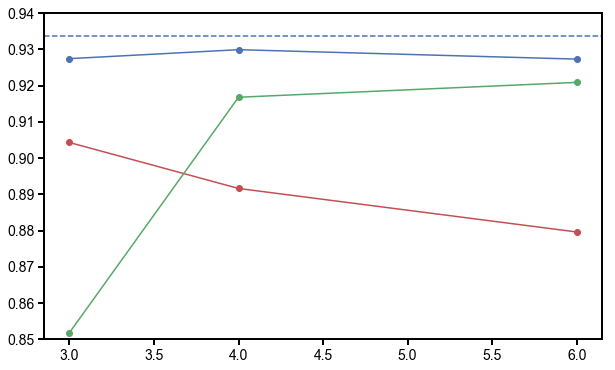

In [19]:


fig, ax = plt.subplots(figsize=(10,6))
ax.plot([d['layers'] for d in models_60f], [d['validation_r2'] for d in models_60f],color='r',marker='o')
ax.plot([d['layers'] for d in models_120f], [d['validation_r2'] for d in models_120f],color='g',marker='o')
ax.plot([d['layers'] for d in models_240f], [d['validation_r2'] for d in models_240f],color='b',marker='o')
ax.set_ylim(0.85,0.94)
# ax.set_xlim(8,59.5)
ax.axhline(y=0.9338, linestyle='--')

# for i, txt in enumerate([d['label'] for d in ]):
#     ax.annotate(txt[:-6], (x[i]-0.8, y[i]-0.001),fontsize=14)

### Do Max Pooling Layers Make a Difference?

In [ ]:
model1 = Sequential()
model1.add(Conv1D(input_shape=(100,4),kernel_size=6,padding='same',filters=10,activation='relu'))
model1.add(MaxPool1D(pool_size=3,padding='same'))
model1.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model1.add(MaxPool1D(pool_size=3,padding='same'))
model1.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model1.add(Flatten())
model1.add(Dense(10))
model1.add(Activation('relu'))
model1.add(Dense(1))
model1.add(Activation('linear'))

In [ ]:
model2 = Sequential()
model2.add(Conv1D(input_shape=(100,4),kernel_size=6,padding='same',filters=10,activation='relu'))
model2.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model2.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model2.add(Flatten())
model2.add(Dense(10))
model2.add(Activation('relu'))
model2.add(Dense(1))
model2.add(Activation('linear'))

In [ ]:
model3 = Sequential()
model3.add(Conv1D(input_shape=(100,4),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Conv1D(input_shape=(100,1),kernel_size=6,padding='same',filters=10,activation='relu'))
model3.add(Flatten())
model3.add(Dense(10))
model3.add(Activation('relu'))
model3.add(Dense(1))
model3.add(Activation('linear'))